In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Переход в рабочую директорию

import os
os.chdir('/content/drive/MyDrive/EEL6812_DeepFool_Project-main')  # Укажите путь к вашей рабочей директории


Mounted at /content/drive


In [2]:
# Скачаем репозиторий с github
!git clone https://github.com/ewatson2/EEL6812_DeepFool_Project.git

fatal: destination path 'EEL6812_DeepFool_Project' already exists and is not an empty directory.


In [3]:
# Перейдём в дирректорию /content/EEL6812_DeepFool_Project
%cd /content/EEL6812_DeepFool_Project

[Errno 2] No such file or directory: '/content/EEL6812_DeepFool_Project'
/content


In [4]:
# Выполним импорт библиотек
import numpy as np
import json, torch
import os
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models
from torchvision.transforms import transforms

In [5]:
# Выполним импорт вспомогательных библиотек из локальных файлов проекта
from models.project_models import FC_500_150, LeNet_CIFAR, LeNet_MNIST, Net
from utils.project_utils import get_clip_bounds, evaluate_attack, display_attack

In [6]:
# Установим случайное рандомное значение в виде переменной (сюда необходимо
# записать порядковый номер в списке, в моём случае это 4)
rand_seed = 4

In [7]:
# Установим указанное значение для np.random.seed и torch.manual_seed
np.random.seed(rand_seed)
torch.manual_seed(rand_seed)

In [8]:
# Используем в качестве устройства видекарту (T4 GPU)
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

In [9]:
# Загрузим датасет MNIST cо следующими параметрами
mnist_mean = 0.5
mnist_std = 0.5
mnist_dim = 28

mnist_min, mnist_max = get_clip_bounds(mnist_mean, mnist_std, mnist_dim)
mnist_min = mnist_min.to(device)
mnist_max = mnist_max.to(device)

mnist_tf = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(mean=mnist_mean, std=mnist_std)])

mnist_tf_train = transforms.Compose([transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=mnist_mean, std=mnist_std)])

mnist_tf_inv = transforms.Compose([transforms.Normalize(mean=0.0, std=np.divide(1.0, mnist_std)),
                                   transforms.Normalize(mean=np.multiply(-1.0, mnist_std), std=1.0)])

mnist_temp = datasets.MNIST(root='datasets/mnist', train=True, download=True, transform=mnist_tf_train)
mnist_train, mnist_val = random_split(mnist_temp, [50000, 10000])
mnist_test = datasets.MNIST(root='datasets/mnist', train=False, download=True, transform=mnist_tf)

In [10]:
# Загрузим датасет CIFAR-10 cо следующими параметрами
cifar_mean = [0.491, 0.482, 0.447]
cifar_std = [0.202, 0.199, 0.201]
cifar_dim = 32

cifar_min, cifar_max = get_clip_bounds(cifar_mean, cifar_std, cifar_dim)
cifar_min = cifar_min.to(device)
cifar_max = cifar_max.to(device)

cifar_tf = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(mean=cifar_mean, std=cifar_std)])

cifar_tf_train = transforms.Compose([transforms.RandomCrop(size=cifar_dim,padding=4),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=cifar_mean, std=cifar_std)])

cifar_tf_inv = transforms.Compose([transforms.Normalize(mean=[0.0, 0.0, 0.0], std=np.divide(1.0, cifar_std)),
                                   transforms.Normalize(mean=np.multiply(-1.0, cifar_mean), std=[1.0, 1.0, 1.0])])

cifar_temp = datasets.CIFAR10(root='datasets/cifar-10', train=True, download=True, transform=cifar_tf_train)
cifar_train, cifar_val = random_split(cifar_temp, [40000, 10000])
cifar_test = datasets.CIFAR10(root='datasets/cifar-10', train=False, download=True, transform=cifar_tf)

cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


In [11]:
# Выполним настройку и загрузку DataLoader
batch_size = 64
workers = 4

mnist_loader_train = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=workers)
mnist_loader_val = DataLoader(mnist_val, batch_size=batch_size, shuffle=False, num_workers=workers)
mnist_loader_test = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=workers)

cifar_loader_train = DataLoader(cifar_train, batch_size=batch_size, shuffle=True, num_workers=workers)
cifar_loader_val = DataLoader(cifar_val, batch_size=batch_size, shuffle=False, num_workers=workers)
cifar_loader_test = DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=workers)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [12]:
# Зададим параметры deep_args
deep_batch_size = 64
deep_num_classes = 10
deep_overshoot = 0.02
deep_max_iters = 100

deep_args = [deep_batch_size, deep_num_classes, deep_overshoot, deep_max_iters]

In [13]:
# Загрузим и оценим стойкость модели Network-In-Network Model к FGSM и DeepFool атакам на основе датасета CIFAR-10
fgsm_eps = 0.2
model = Net().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_nin.pth',map_location=torch.device('cpu')))

evaluate_attack('cifar_nin_fgsm.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max, fgsm_eps, is_fgsm=True)
print('')
evaluate_attack('cifar_nin_deepfool.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max, deep_args, is_fgsm=False)

if device.type == 'cuda': torch.cuda.empty_cache()

<ipython-input-13-a5434b034ce5>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_nin.pth',map_location=torch.device('cp

FGSM Test Error : 81.29%
FGSM Robustness : 1.77e-01
FGSM Time (All Images) : 0.67 s
FGSM Time (Per Image) : 67.07 us

DeepFool Test Error : 93.76%
DeepFool Robustness : 2.12e-02
DeepFool Time (All Images) : 185.12 s
DeepFool Time (Per Image) : 18.51 ms


In [14]:
# Загрузим и оценим стойкость модели LeNet к FGSM и DeepFool атакам на основе датасета CIFAR-10
fgsm_eps = 0.1
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth', map_location=torch.device('cpu')))

evaluate_attack('cifar_lenet_fgsm.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max, fgsm_eps, is_fgsm=True)
print('')
evaluate_attack('cifar_lenet_deepfool.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max, deep_args, is_fgsm=False)

if device.type == 'cuda': torch.cuda.empty_cache()

<ipython-input-14-08045a679969>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth', map_location=torch.device(

FGSM Test Error : 91.71%
FGSM Robustness : 8.90e-02
FGSM Time (All Images) : 0.40 s
FGSM Time (Per Image) : 40.08 us

DeepFool Test Error : 87.81%
DeepFool Robustness : 1.78e-02
DeepFool Time (All Images) : 73.27 s
DeepFool Time (Per Image) : 7.33 ms


Running attacks for: LeNet on MNIST dataset


<ipython-input-16-7539c648a6f2>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))


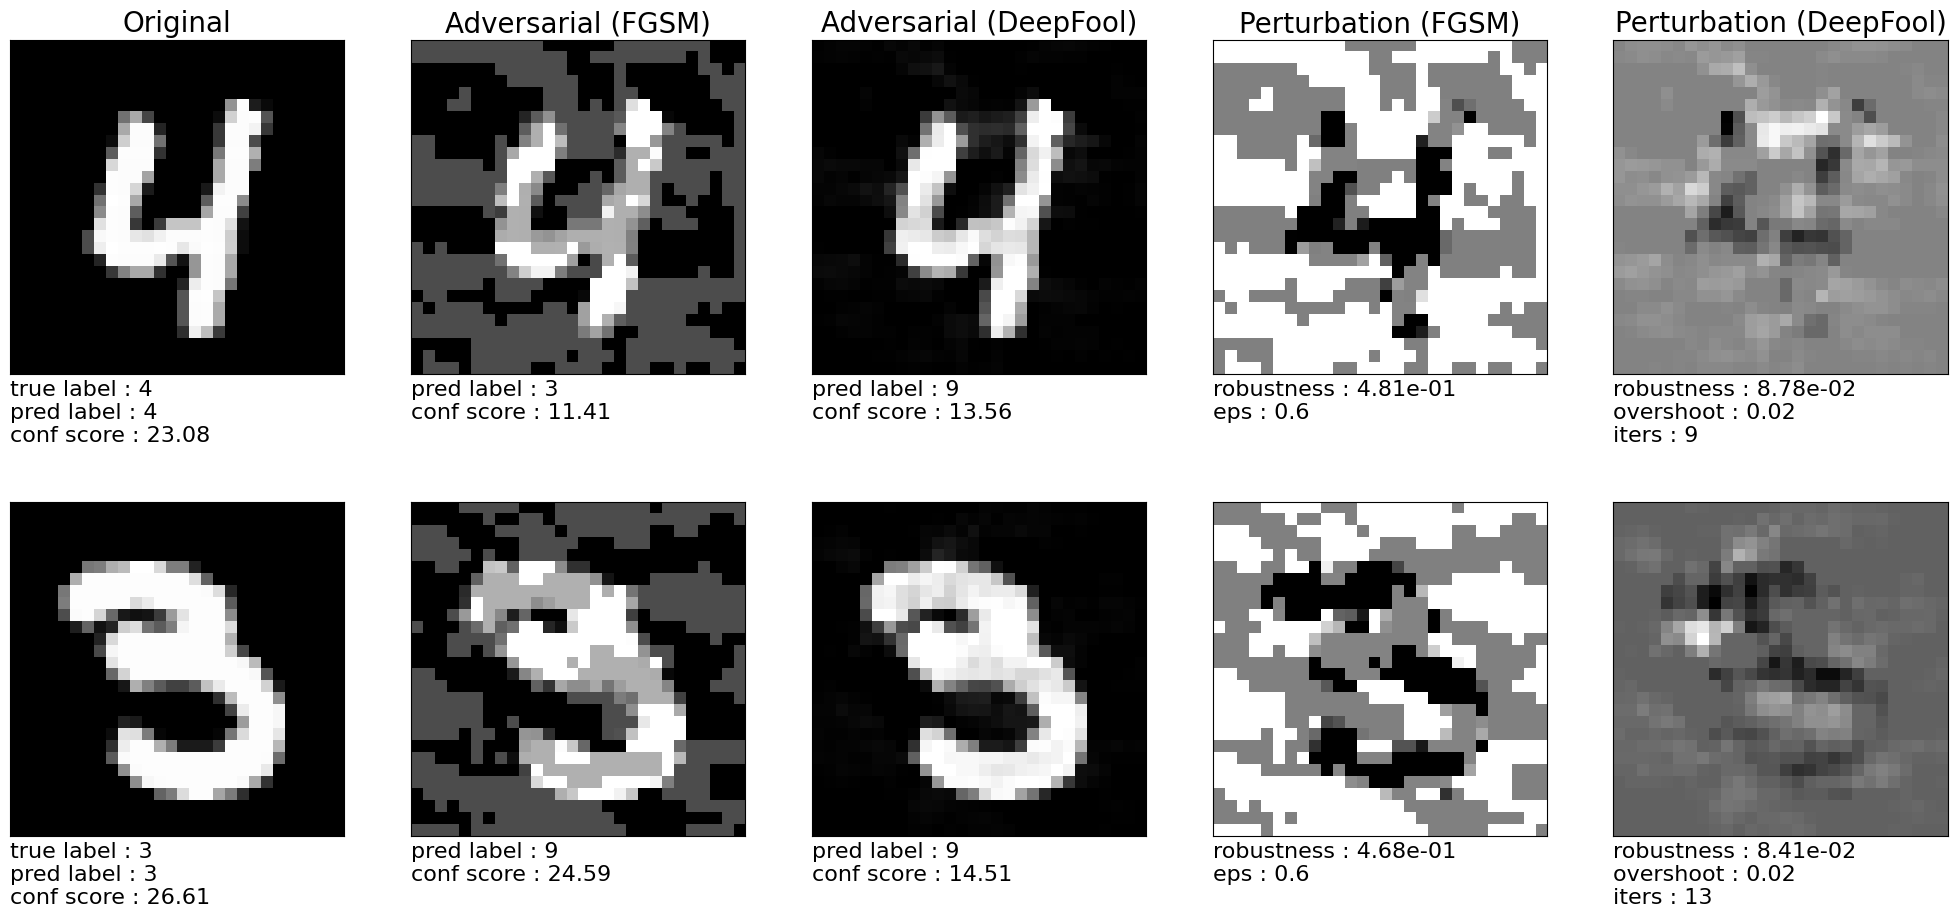

Running attacks for: FCNet on MNIST dataset


<ipython-input-16-7539c648a6f2>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))


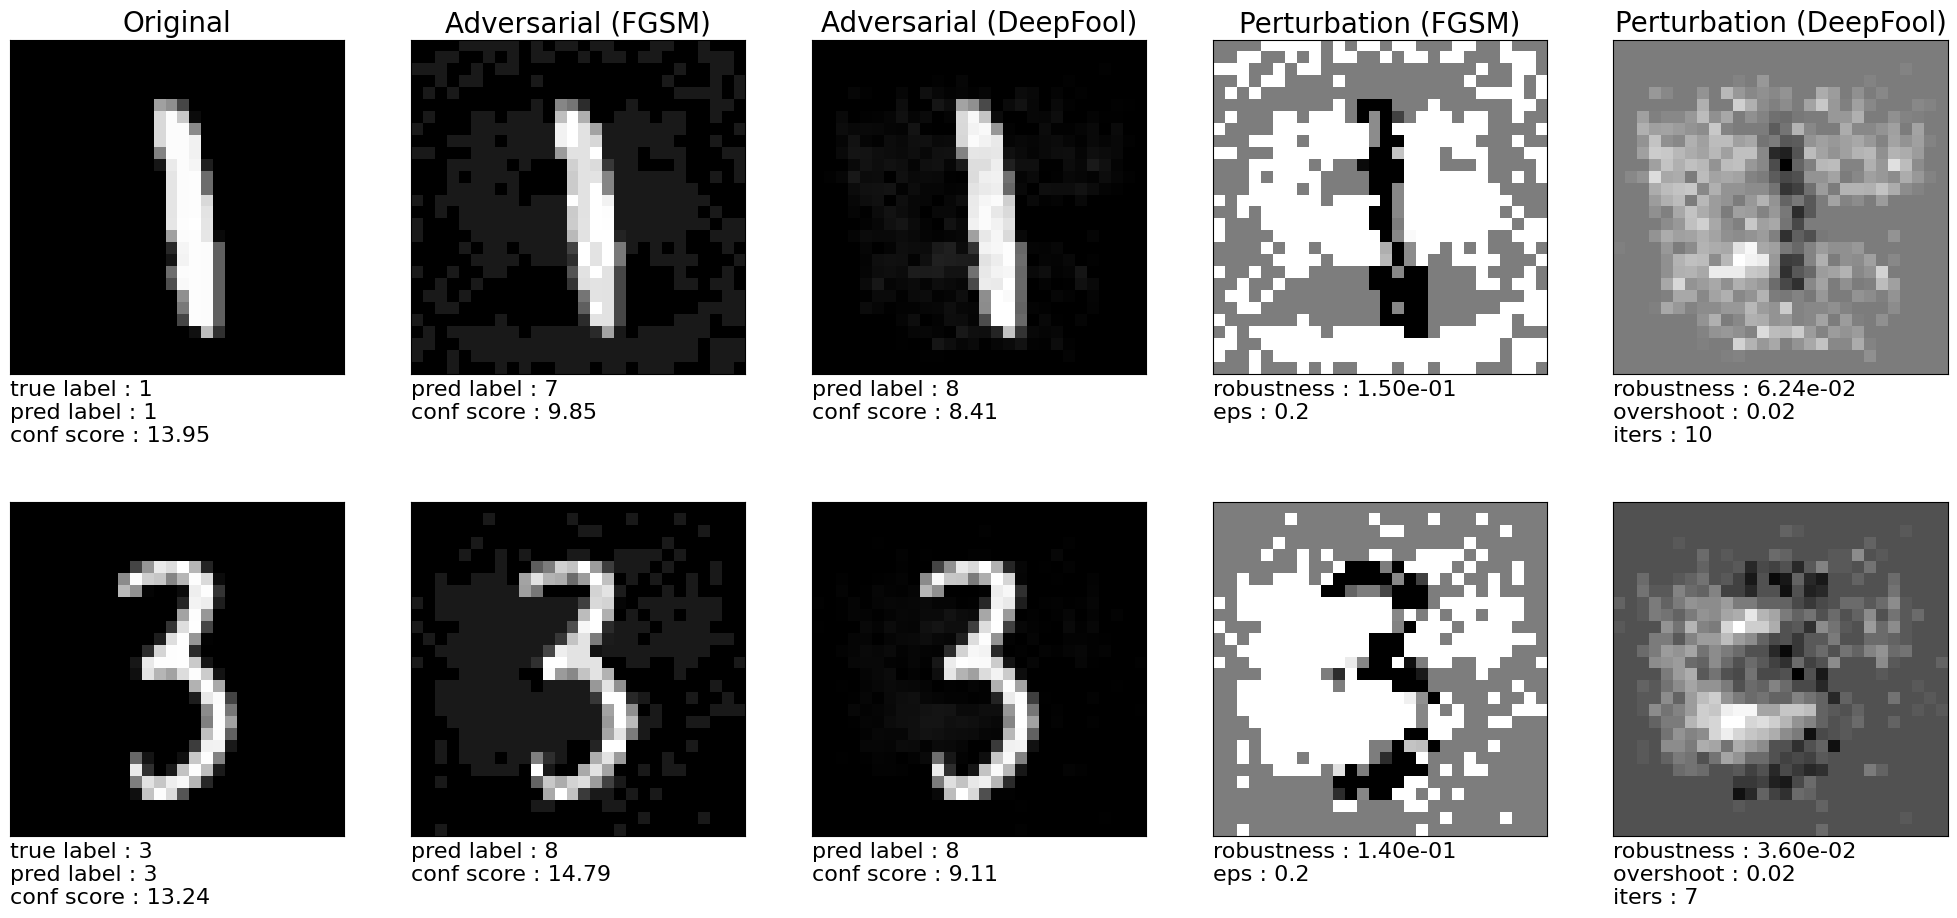

Running attacks for: Network-in-Network on CIFAR-10 dataset


<ipython-input-16-7539c648a6f2>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))


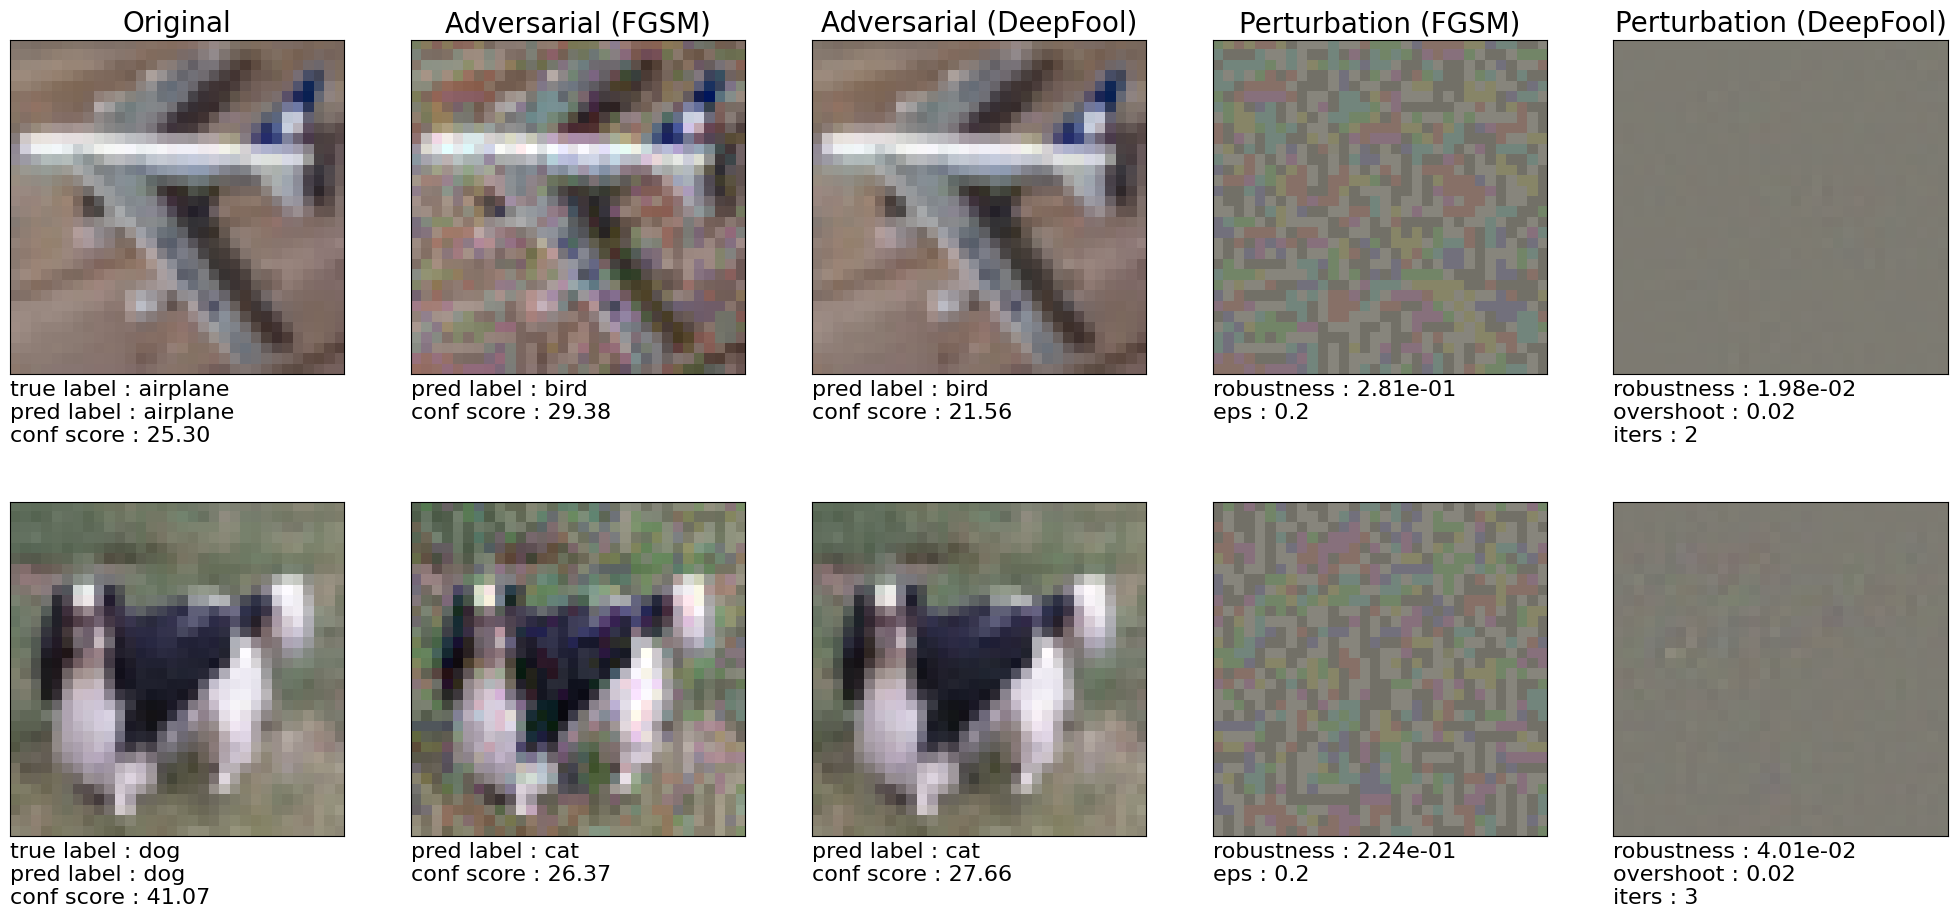

Running attacks for: LeNet on CIFAR-10 dataset


<ipython-input-16-7539c648a6f2>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))


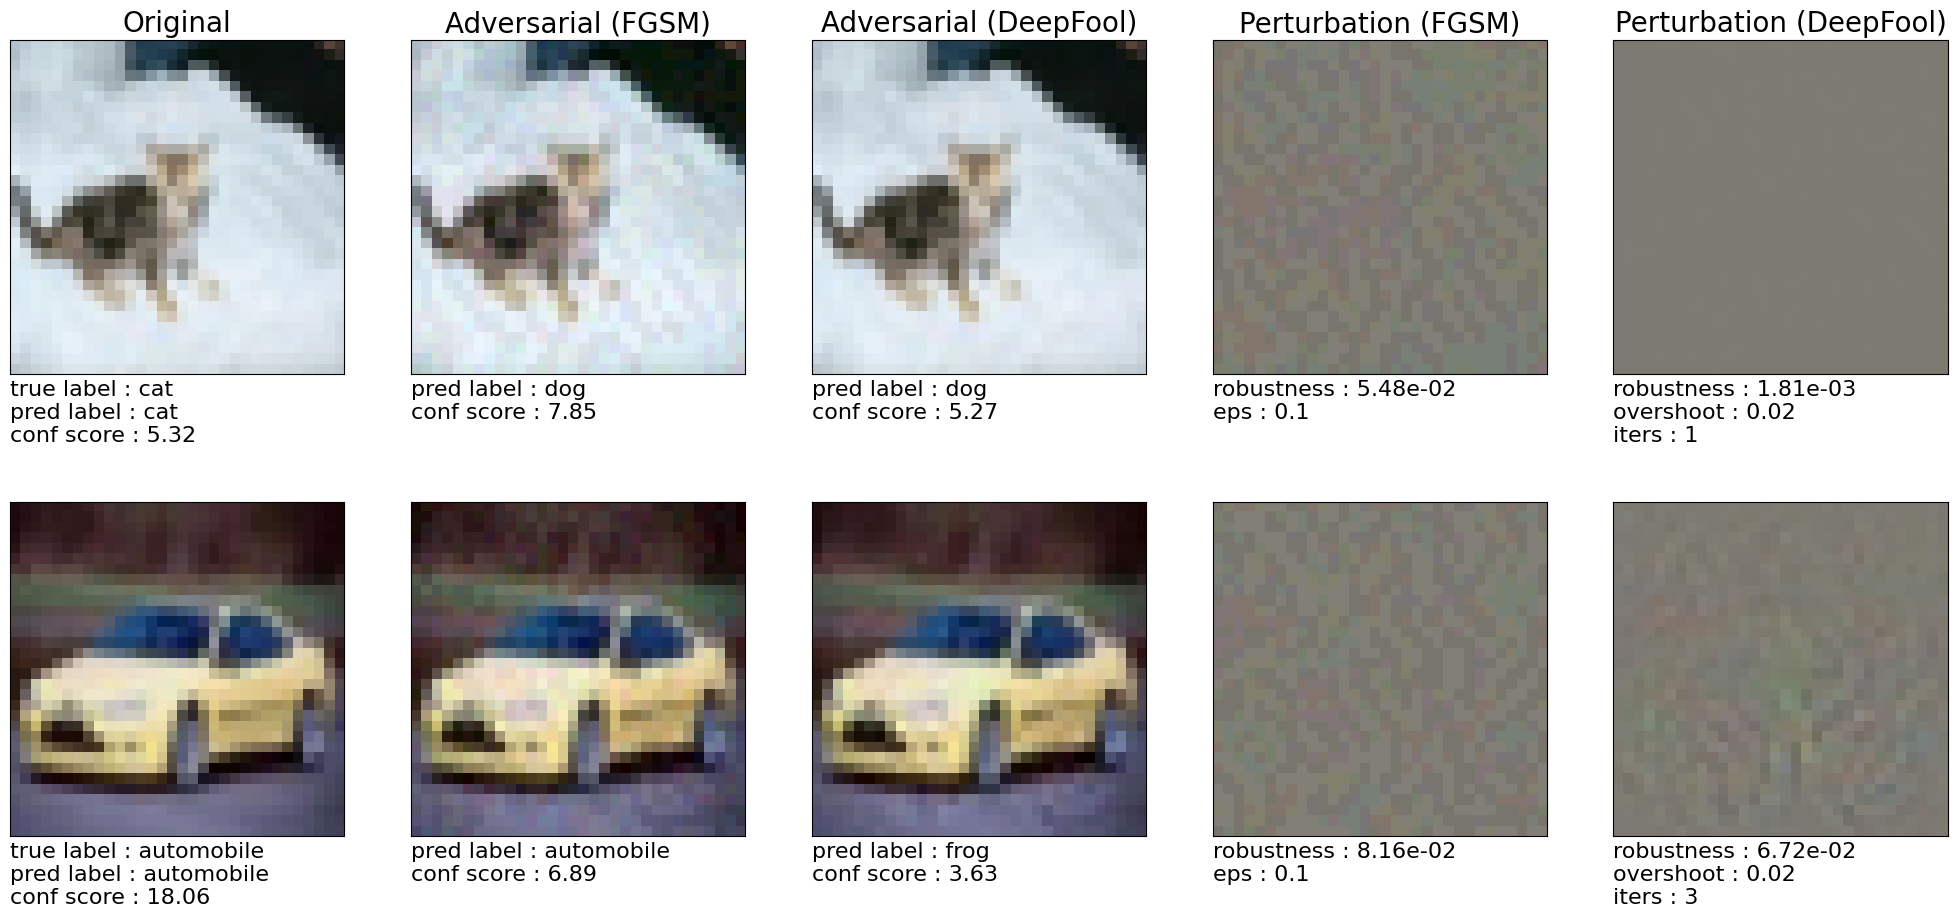

In [16]:
# Выполним оценку атакующих примеров для сетей:

# LeNet на датасете MNIST
print("Running attacks for: LeNet on MNIST dataset")
fgsm_eps = 0.6
model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))
display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)

if device.type == 'cuda': torch.cuda.empty_cache()

# FCNet на датасете MNIST
print("Running attacks for: FCNet on MNIST dataset")
fgsm_eps = 0.2
model = FC_500_150().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))
display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)

if device.type == 'cuda': torch.cuda.empty_cache()

# Network-in-Network на датасете CIFAR-10
print("Running attacks for: Network-in-Network on CIFAR-10 dataset")
fgsm_eps = 0.2
model = Net().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))
display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11, label_map=cifar_classes)

if device.type == 'cuda': torch.cuda.empty_cache()

# LeNet на датасете CIFAR-10
print("Running attacks for: LeNet on CIFAR-10 dataset")
fgsm_eps = 0.1
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))
display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11, label_map=cifar_classes)

if device.type == 'cuda': torch.cuda.empty_cache()


In [36]:
import io
import sys
import pandas as pd

# Создадим список со значениями eps для FGSM атаки, которые мы хотим исследовать
fgsm_eps_list = [0.001, 0.02, 0.5, 0.9, 10]

# Создадим DataFrame для хранения результатов
results_table = pd.DataFrame(columns=[
    "Dataset", "Model", "FGSM_eps", "TIME (All Images) [s]", "TIME (Per Image) [us]", "Test Error [%]", "Robustness"
])

# Настраиваем отображение таблицы
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: f'{x:.4f}')

# Создадим цикл для перебора различных значений eps
for fgsm_eps in fgsm_eps_list:
    print(f"\nEvaluating FGSM Attack with eps={fgsm_eps}...\n")

    # Обработка для MNIST
    model = FC_500_150().to(device)
    model.load_state_dict(torch.load('weights/clean/mnist_fc.pth', map_location=device))
    old_stdout = sys.stdout
    new_stdout = io.StringIO()
    sys.stdout = new_stdout

    # Вызов evaluate_attack
    evaluate_attack(f'mnist_fc_fgsm_eps{fgsm_eps}.csv', 'results', device, model, mnist_loader_test, mnist_min, mnist_max, fgsm_eps, is_fgsm=True)

    sys.stdout = old_stdout
    output = new_stdout.getvalue()

    # Парсим данные из вывода
    lines = output.splitlines()
    if len(lines) >= 4:  # Убедимся, что вывод содержит необходимые строки
        test_error = float(lines[0].split(':')[1].strip().replace('%', ''))
        robustness = float(lines[1].split(':')[1].strip())
        time_all = float(lines[2].split(':')[1].strip().split()[0])
        time_per_image = float(lines[3].split(':')[1].strip().split()[0])

        # Добавляем результат для MNIST в таблицу
        results_table = pd.concat([results_table, pd.DataFrame([{
            "Dataset": "MNIST",
            "Model": "FC LeNet",
            "FGSM_eps": fgsm_eps,
            "TIME (All Images) [s]": time_all,
            "TIME (Per Image) [us]": time_per_image,
            "Test Error [%]": test_error,
            "Robustness": robustness
        }])], ignore_index=True)

    # Обработка для CIFAR-10
    model = Net().to(device)
    model.load_state_dict(torch.load('weights/clean/cifar_nin.pth', map_location=device))
    new_stdout = io.StringIO()
    sys.stdout = new_stdout

    # Вызов evaluate_attack
    evaluate_attack(f'cifar_nin_fgsm_eps{fgsm_eps}.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max, fgsm_eps, is_fgsm=True)

    sys.stdout = old_stdout
    output = new_stdout.getvalue()

    # Парсим данные из вывода
    lines = output.splitlines()
    if len(lines) >= 4:  # Убедимся, что вывод содержит необходимые строки
        test_error = float(lines[0].split(':')[1].strip().replace('%', ''))
        robustness = float(lines[1].split(':')[1].strip())
        time_all = float(lines[2].split(':')[1].strip().split()[0])
        time_per_image = float(lines[3].split(':')[1].strip().split()[0])

        # Добавляем результат для CIFAR-10 в таблицу
        results_table = pd.concat([results_table, pd.DataFrame([{
            "Dataset": "CIFAR-10",
            "Model": "Network-in-Network",
            "FGSM_eps": fgsm_eps,
            "TIME (All Images) [s]": time_all,
            "TIME (Per Image) [us]": time_per_image,
            "Test Error [%]": test_error,
            "Robustness": robustness
        }])], ignore_index=True)

    # Очистка памяти GPU
    if device.type == 'cuda':
        torch.cuda.empty_cache()

# Выводим итоговую таблицу
print("\nFinal Results Table:")
print(results_table)

# Сохраняем результаты в CSV
results_table.to_csv("fgsm_attack_results_comparison.csv", index=False)




Evaluating FGSM Attack with eps=0.001...


Evaluating FGSM Attack with eps=0.02...


Evaluating FGSM Attack with eps=0.5...


Evaluating FGSM Attack with eps=0.9...


Evaluating FGSM Attack with eps=10...



<ipython-input-36-b4c55a3e689d>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/mnist_fc.pth', map_location=device))
<ipyth


Final Results Table:
   Dataset         Model         FGSM_eps  TIME (All Images) [s]  TIME (Per Image) [us]  Test Error [%]  Robustness
0     MNIST            FC LeNet   0.0010          0.5900                 59.2000             3.0700        0.0008  
1  CIFAR-10  Network-in-Network   0.0010          1.4900                148.6000            10.1200        0.0009  
2     MNIST            FC LeNet   0.0200          0.5900                 59.1900             5.5400        0.0160  
3  CIFAR-10  Network-in-Network   0.0200          1.1400                114.4900            30.7600        0.0178  
4     MNIST            FC LeNet   0.5000          0.6400                 63.5700            99.2100        0.3860  
5  CIFAR-10  Network-in-Network   0.5000          1.2900                129.3000            82.6700        0.4400  
6     MNIST            FC LeNet   0.9000          0.5500                 55.3300            99.8700        0.6860  
7  CIFAR-10  Network-in-Network   0.9000          

<ipython-input-36-b4c55a3e689d>:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_nin.pth', map_location=device))
